In [29]:
# Write a function 'kalman_filter' that implements a multi-
# dimensional Kalman Filter for the example given
from math import sqrt

class matrix:
    # implements basic operations of a matrix class
    def __init__(self, value):
        self.value = value
        self.dimx = len(value)
        self.dimy = len(value[0]) if value != [[]] else 0

    def zero(self, dimx, dimy):
        if dimx < 1 or dimy < 1:
            raise ValueError("Invalid size of matrix")
        self.dimx = dimx
        self.dimy = dimy
        self.value = [[0 for _ in range(dimy)] for _ in range(dimx)]

    def identity(self, dim):
        if dim < 1:
            raise ValueError("Invalid size of matrix")
        self.dimx = dim
        self.dimy = dim
        self.value = [[0 for _ in range(dim)] for _ in range(dim)]
        for i in range(dim):
            self.value[i][i] = 1

    def show(self):
        for i in range(self.dimx):
            print(self.value[i])
        print(' ')

    def __add__(self, other):
        if self.dimx != other.dimx or self.dimy != other.dimy:
            raise ValueError("Matrices must be of equal dimensions to add")
        res = matrix([[]])
        res.zero(self.dimx, self.dimy)
        for i in range(self.dimx):
            for j in range(self.dimy):
                res.value[i][j] = self.value[i][j] + other.value[i][j]
        return res

    def __sub__(self, other):
        if self.dimx != other.dimx or self.dimy != other.dimy:
            raise ValueError("Matrices must be of equal dimensions to subtract")
        res = matrix([[]])
        res.zero(self.dimx, self.dimy)
        for i in range(self.dimx):
            for j in range(self.dimy):
                res.value[i][j] = self.value[i][j] - other.value[i][j]
        return res

    def __mul__(self, other):
        if self.dimy != other.dimx:
            raise ValueError("Matrices must be m*n and n*p to multiply")
        res = matrix([[]])
        res.zero(self.dimx, other.dimy)
        for i in range(self.dimx):
            for j in range(other.dimy):
                for k in range(self.dimy):
                    res.value[i][j] += self.value[i][k] * other.value[k][j]
        return res

    def transpose(self):
        res = matrix([[]])
        res.zero(self.dimy, self.dimx)
        for i in range(self.dimx):
            for j in range(self.dimy):
                res.value[j][i] = self.value[i][j]
        return res

    def Cholesky(self, ztol=1.0e-5):
        res = matrix([[]])
        res.zero(self.dimx, self.dimx)

        for i in range(self.dimx):
            S = sum([(res.value[k][i]) ** 2 for k in range(i)])
            d = self.value[i][i] - S
            if abs(d) < ztol:
                res.value[i][i] = 0.0
            else:
                if d < 0.0:
                    raise ValueError("Matrix not positive-definite")
                res.value[i][i] = sqrt(d)
            for j in range(i + 1, self.dimx):
                S = sum([res.value[k][i] * res.value[k][j] for k in range(i)])
                if abs(S) < ztol:
                    S = 0.0
                res.value[i][j] = (self.value[i][j] - S) / res.value[i][i]
        return res

    def CholeskyInverse(self):
        res = matrix([[]])
        res.zero(self.dimx, self.dimx)

        for j in reversed(range(self.dimx)):
            tjj = self.value[j][j]
            S = sum([self.value[j][k] * res.value[j][k] for k in range(j + 1, self.dimx)])
            res.value[j][j] = 1.0 / tjj ** 2 - S / tjj
            for i in reversed(range(j)):
                S = sum([self.value[i][k] * res.value[k][j] for k in range(i + 1, self.dimx)])
                res.value[i][j] = res.value[j][i] = -S / self.value[i][i]
        return res

    def inverse(self):
        aux = self.Cholesky()
        res = aux.CholeskyInverse()
        return res

    def __repr__(self):
        return repr(self.value)


########################################
# Implement the Kalman filter
########################################

def kalman_filter(x, P):
    for n in range(len(measurements)):
        # measurement update
        Z = matrix([[measurements[n]]])
        y = Z - (H * x)
        S = H * P * H.transpose() + R
        K = P * H.transpose() * S.inverse()
        x = x + (K * y)
        P = (I - (K * H)) * P

        # prediction
        x = (F * x) + u
        P = F * P * F.transpose() + Q
    return x, P


############################################
### use the code below to test your filter!
############################################

measurements = [1, 2, 3]

x = matrix([[0.], [0.]]) # initial state [position,velocity](we don't know the position and velocity)
P = matrix([[1000., 0.], [0., 1000.]]) # initial uncertainty it is now represented as a 2D matrix (higher in the position and velocity)
u = matrix([[0.], [0.]]) # “what I know the system is doing”
F = matrix([[1., 1.], [0, 1.]]) # next state function as H in the slides (velocity is added to the position as before)
H = matrix([[1., 0.]]) # measurement function (we observe the position but not the velocity)
R = matrix([[1.]]) # measurement uncertainty
I = matrix([[1., 0.], [0., 1.]]) # identity matrix
Q = matrix([[0.1, 0.], [0., 0.1]])  # random uncertainty in the model  “how much I don’t trust that knowledge”
#we first print the measurement update and then the prediction
print(kalman_filter(x, P)) #result: x (final state position and velocity), P (final uncertainty)

# output should be:
# x: [[3.9996664447958645], [0.9999998335552873]] #position and velocity
# P: [[2.3318904241194827, 0.9991676099921091], [0.9991676099921067, 0.49950058263974184]] #the uncertainties decreases


([[3.9996331845261754], [0.9999665378618711]], [[2.6302888957207338, 1.181685883638815], [1.1816858836388109, 0.7740856304722231]])


The output of the `kalman_filter` function is a tuple containing two elements:

1.  **The final estimated state `x`**: This is a matrix representing the filter's best estimate of the system's state after processing all the measurements. In this example, `x` is a 2x1 matrix where the first element is the estimated position and the second element is the estimated velocity.

2.  **The final uncertainty covariance matrix `P`**: This is a matrix that quantifies the uncertainty in the estimated state. The diagonal elements represent the variance of each state variable (position and velocity), and the off-diagonal elements represent the covariance between the state variables. As the filter incorporates more measurements, the values in this matrix should ideally decrease, indicating reduced uncertainty in the state estimate.

In [30]:
from math import sqrt
import matplotlib.pyplot as plt


class matrix:
    def __init__(self, value):
        self.value = value
        self.dimx = len(value)
        self.dimy = len(value[0]) if value != [[]] else 0

    def zero(self, dimx, dimy):
        if dimx < 1 or dimy < 1:
            raise ValueError("Invalid size of matrix")
        self.dimx = dimx
        self.dimy = dimy
        self.value = [[0 for _ in range(dimy)] for _ in range(dimx)]

    def identity(self, dim):
        if dim < 1:
            raise ValueError("Invalid size of matrix")
        self.dimx = dim
        self.dimy = dim
        self.value = [[0 for _ in range(dim)] for _ in range(dim)]
        for i in range(dim):
            self.value[i][i] = 1

    def __add__(self, other):
        res = matrix([[]])
        res.zero(self.dimx, self.dimy)
        for i in range(self.dimx):
            for j in range(self.dimy):
                res.value[i][j] = self.value[i][j] + other.value[i][j]
        return res

    def __sub__(self, other):
        res = matrix([[]])
        res.zero(self.dimx, self.dimy)
        for i in range(self.dimx):
            for j in range(self.dimy):
                res.value[i][j] = self.value[i][j] - other.value[i][j]
        return res

    def __mul__(self, other):
        if self.dimy != other.dimx:
            raise ValueError("Matrix dimensions mismatch for multiplication")
        res = matrix([[]])
        res.zero(self.dimx, other.dimy)
        for i in range(self.dimx):
            for j in range(other.dimy):
                for k in range(self.dimy):
                    res.value[i][j] += self.value[i][k] * other.value[k][j]
        return res

    def transpose(self):
        res = matrix([[]])
        res.zero(self.dimy, self.dimx)
        for i in range(self.dimx):
            for j in range(self.dimy):
                res.value[j][i] = self.value[i][j]
        return res

    def Cholesky(self, ztol=1.0e-5):
        res = matrix([[]])
        res.zero(self.dimx, self.dimx)
        for i in range(self.dimx):
            S = sum([(res.value[k][i]) ** 2 for k in range(i)])
            d = self.value[i][i] - S
            if abs(d) < ztol:
                res.value[i][i] = 0.0
            else:
                if d < 0.0:
                    raise ValueError("Matrix not positive-definite")
                res.value[i][i] = sqrt(d)
            for j in range(i + 1, self.dimx):
                S = sum([res.value[k][i] * res.value[k][j] for k in range(i)])
                res.value[i][j] = (self.value[i][j] - S) / res.value[i][i]
        return res

    def CholeskyInverse(self):
        res = matrix([[]])
        res.zero(self.dimx, self.dimx)
        for j in reversed(range(self.dimx)):
            tjj = self.value[j][j]
            S = sum([self.value[j][k] * res.value[j][k] for k in range(j + 1, self.dimx)])
            res.value[j][j] = 1.0 / tjj ** 2 - S / tjj
            for i in reversed(range(j)):
                S = sum([self.value[i][k] * res.value[k][j] for k in range(i + 1, self.dimx)])
                res.value[i][j] = res.value[j][i] = -S / self.value[i][i]
        return res

    def inverse(self):
        aux = self.Cholesky()
        res = aux.CholeskyInverse()
        return res

    def __repr__(self):
        return repr(self.value)


# ------------------------------------------
# Original Kalman filter (using global vars)
# ------------------------------------------
def kalman_filter(x, P):
    positions = []
    velocities = []
    uncertainties = []

    for n in range(len(measurements)):
        # Measurement update
        Z = matrix([[measurements[n]]])
        y = Z - (H * x)
        S = H * P * H.transpose() + R
        K = P * H.transpose() * S.inverse()
        x = x + (K * y)
        P = (I - (K * H)) * P

        positions.append(x.value[0][0])
        velocities.append(x.value[1][0])
        uncertainties.append(P.value[0][0])

        # Prediction
        x = (F * x) + u
        P = F * P * F.transpose() + Q

    return x, P, positions, velocities, uncertainties

Final state (x): [[9.000069200532035], [1.0000305556466846]]
Final uncertainty (P): [[1.3742177252921672, 0.4873322902500316], [0.4873322902500316, 0.38179574390960513]]


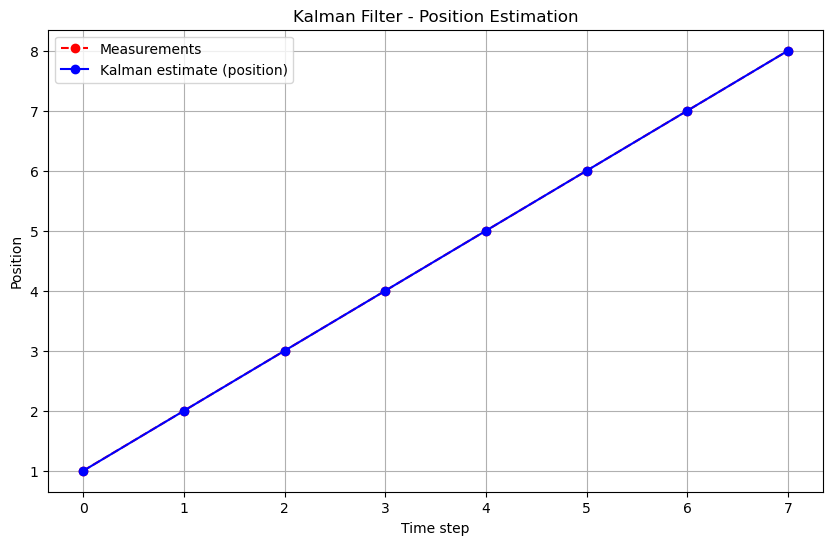

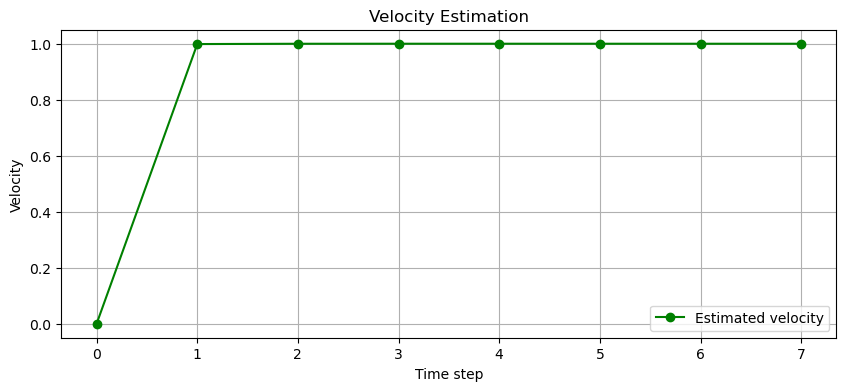

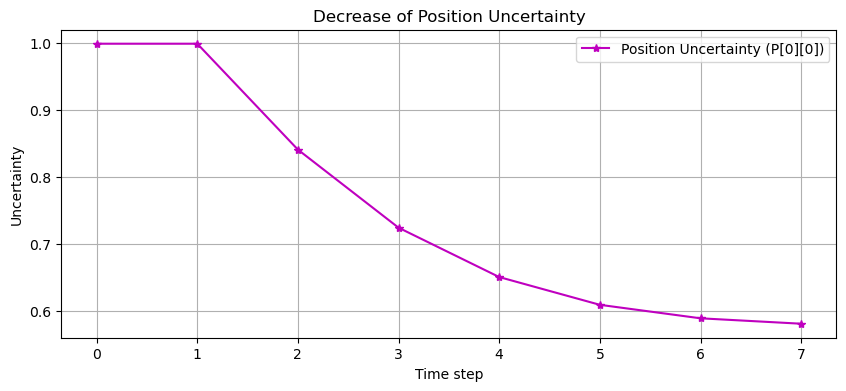

In [31]:

# ------------------------------------------
# Base configuration
# ------------------------------------------
measurements = [1, 2, 3, 4, 5, 6, 7, 8]
x = matrix([[0.], [0.]])
P = matrix([[1000., 0.], [0., 1000.]])
u = matrix([[0.], [0.]])
F = matrix([[1., 1.], [0, 1.]])
H = matrix([[1., 0.]])
R = matrix([[1.]])
I = matrix([[1., 0.], [0., 1.]])

# Run
x, P, positions, velocities, uncertainties = kalman_filter(x, P)

print("Final state (x):", x)
print("Final uncertainty (P):", P)

# ------------------------------------------
# Visualization
# ------------------------------------------
time = list(range(len(measurements)))

plt.figure(figsize=(10, 6))
plt.plot(time, measurements, 'ro--', label='Measurements')
plt.plot(time, positions, 'bo-', label='Kalman estimate (position)')
plt.xlabel('Time step')
plt.ylabel('Position')
plt.title('Kalman Filter - Position Estimation')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(time, velocities, 'go-', label='Estimated velocity')
plt.xlabel('Time step')
plt.ylabel('Velocity')
plt.title('Velocity Estimation')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(time, uncertainties, 'm*-', label='Position Uncertainty (P[0][0])')
plt.xlabel('Time step')
plt.ylabel('Uncertainty')
plt.title('Decrease of Position Uncertainty')
plt.legend()
plt.grid(True)
plt.show()






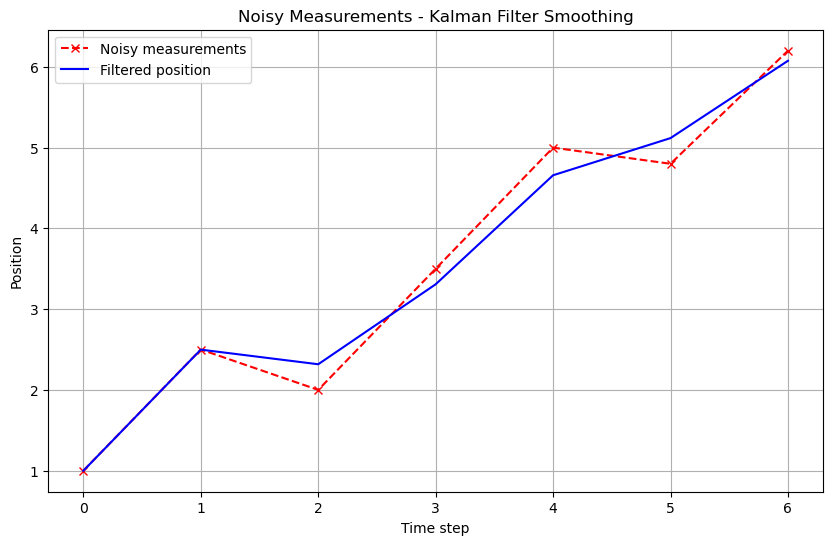

In [32]:
# ------------------------------------------
# EXAMPLES
# ------------------------------------------

# Example 1: Noisy measurements
measurements = [1, 2.5, 2.0, 3.5, 5.0, 4.8, 6.2]
x = matrix([[0.], [0.]])
P = matrix([[1000., 0.], [0., 1000.]])
x, P, positions, velocities, uncertainties = kalman_filter(x, P)

plt.figure(figsize=(10, 6))
plt.plot(range(len(measurements)), measurements, 'rx--', label='Noisy measurements')
plt.plot(range(len(measurements)), positions, 'b-', label='Filtered position')
plt.xlabel('Time step')
plt.ylabel('Position')
plt.title('Noisy Measurements - Kalman Filter Smoothing')
plt.legend()
plt.grid(True)
plt.show()

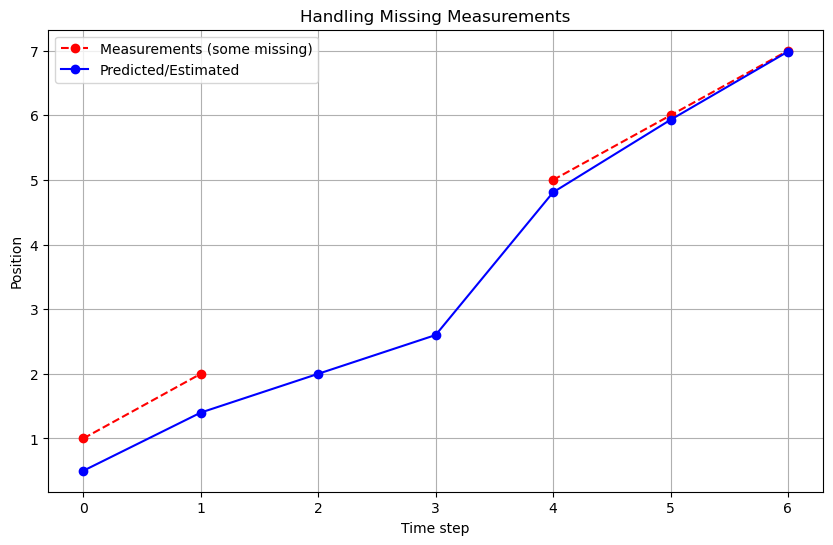

In [33]:
# Example 2: Missing measurement
measurements = [1, 2, None, None, 5, 6, 7]
x = matrix([[0.], [0.]])
P = matrix([[1000., 0.], [0., 1000.]])
R = matrix([[1000.]])

positions = []
measurements_used = []
for n in range(len(measurements)):
    if measurements[n] is not None:
        Z = matrix([[measurements[n]]])
        y = Z - (H * x)
        S = H * P * H.transpose() + R
        K = P * H.transpose() * S.inverse()
        x = x + (K * y)
        P = (I - (K * H)) * P + Q
        measurements_used.append(measurements[n])
    else:
        measurements_used.append(float('nan'))

    positions.append(x.value[0][0])
    x = (F * x) + u
    P = F * P * F.transpose()

plt.figure(figsize=(10, 6))
plt.plot(range(len(measurements)), measurements_used, 'ro--', label='Measurements (some missing)')
plt.plot(range(len(positions)), positions, 'bo-', label='Predicted/Estimated')
plt.xlabel('Time step')
plt.ylabel('Position')
plt.title('Handling Missing Measurements')
plt.legend()
plt.grid(True)
plt.show()


In [34]:
# === Utility plotting ===
def plot_results(title, measurements, positions, velocities, uncertainties):
    t = range(len(measurements))
    plt.figure(figsize=(10, 6))
    plt.plot(t, measurements, 'ro--', label='Measurements')
    plt.plot(t, positions, 'bo-', label='Kalman position estimate')
    plt.title(title + " — Position")
    plt.xlabel('Time step')
    plt.ylabel('Position')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 4))
    plt.plot(t, velocities, 'go-', label='Velocity estimate')
    plt.title(title + " — Velocity")
    plt.xlabel('Time step')
    plt.ylabel('Velocity')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 4))
    plt.plot(t, uncertainties, 'm*-', label='Position uncertainty P[0,0]')
    plt.title(title + " — Uncertainty evolution")
    plt.xlabel('Time step')
    plt.ylabel('Uncertainty')
    plt.legend()
    plt.grid(True)
    plt.show()

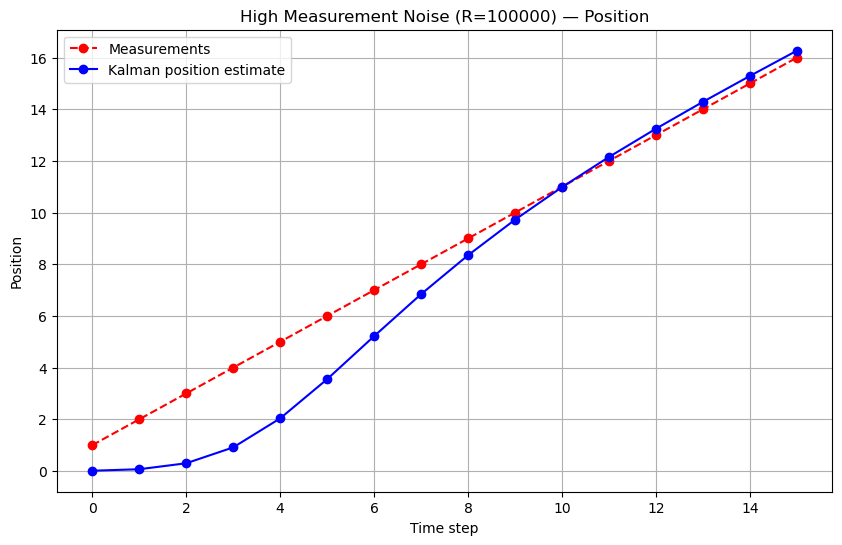

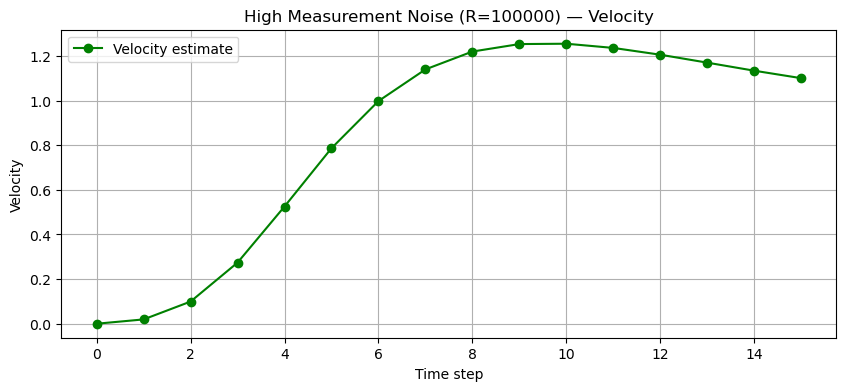

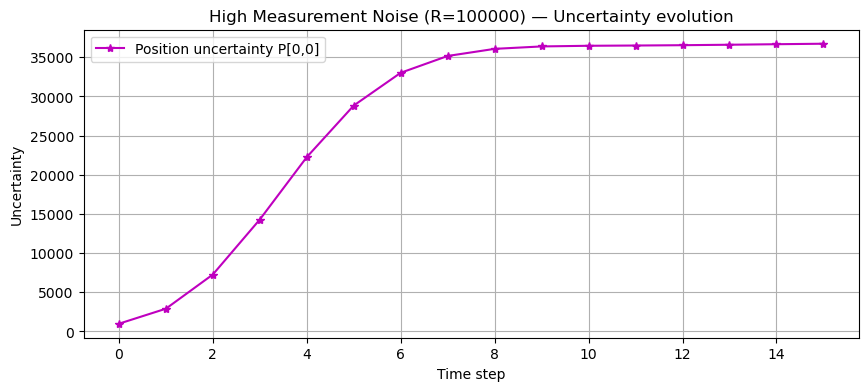

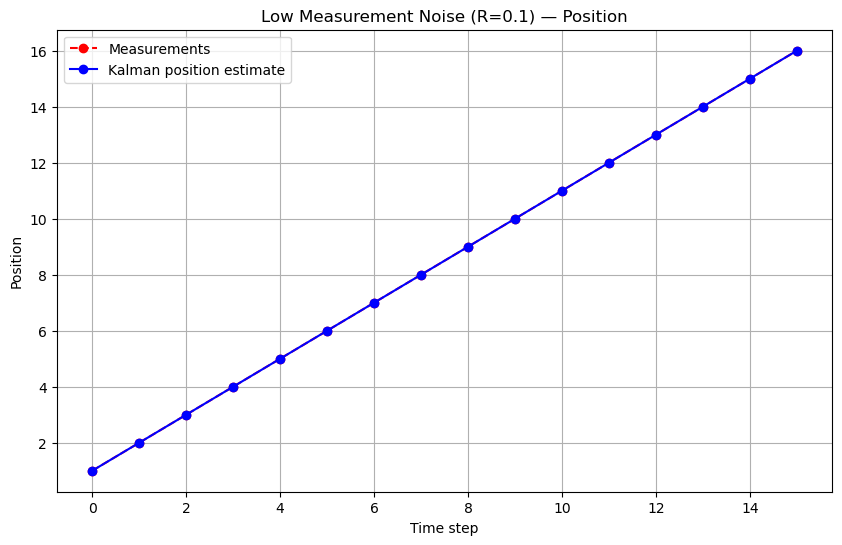

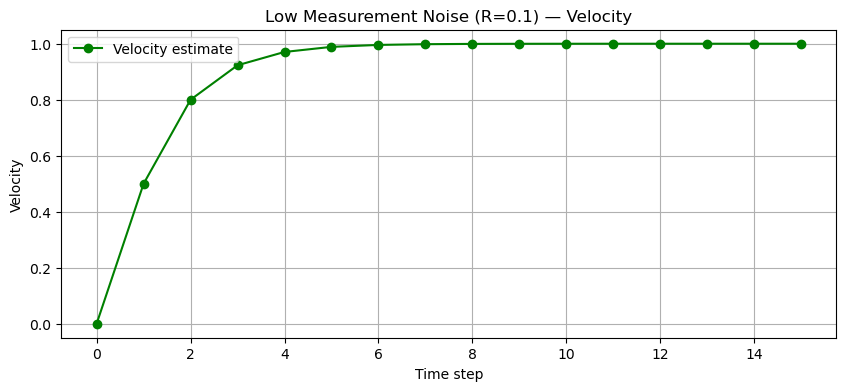

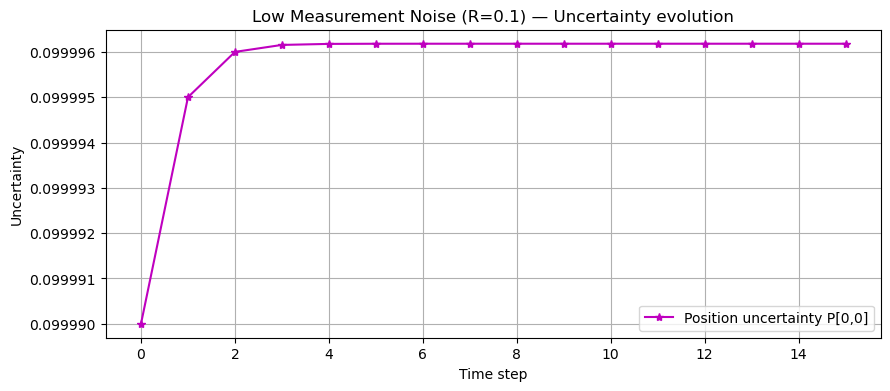

In [40]:
import random
# === Base model setup ===
u = matrix([[0.], [0.]])
F = matrix([[1., 1.], [0., 1.]])
H = matrix([[1., 0.]])
I = matrix([[1., 0.], [0., 1.]])
R = matrix([[100000.]])
Q = matrix([[0., 0.], [0., 0.]])  # default (no process noise)
x = matrix([[0.], [0.]])
P = matrix([[1000., 0.], [0., 1000.]])


# ----------------------------------------------------------------
# Example 1: Measurement Noise Sensitivity
# ----------------------------------------------------------------
measurements = range(1,17)
Q = matrix([[1000., 0.], [0., 1000.]])  # default (this is the predict noise)

x, P, positions, velocities, uncertainties = kalman_filter(x, P)
plot_results("High Measurement Noise (R=100000)", measurements, positions, velocities, uncertainties)

R = matrix([[0.1]])  # Lower measurement noise
x = matrix([[0.], [0.]])
P = matrix([[1000., 0.], [0., 1000.]])
x, P, positions, velocities, uncertainties = kalman_filter(x, P)
plot_results("Low Measurement Noise (R=0.1)", measurements, positions, velocities, uncertainties)

# 👉 Insight:
#   - High R => Filter trusts measurements less → smoother but slower response.
#   - Low R  => Filter trusts measurements more → faster but noisier tracking.


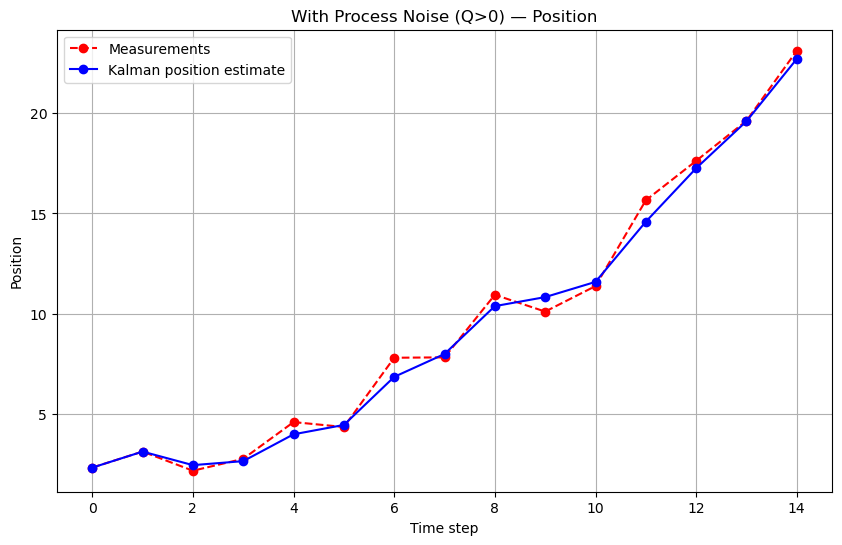

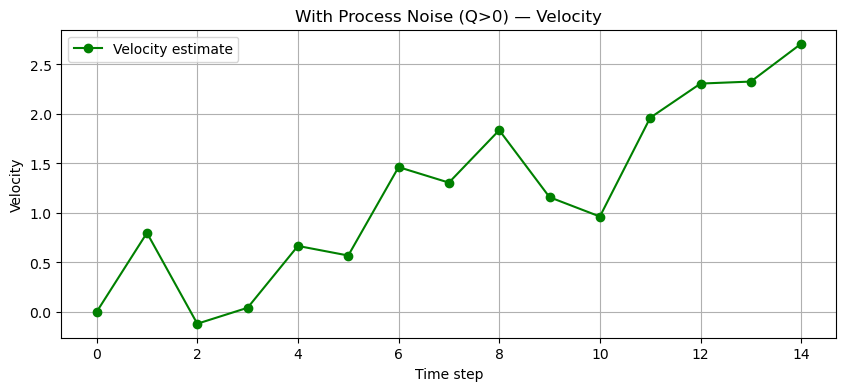

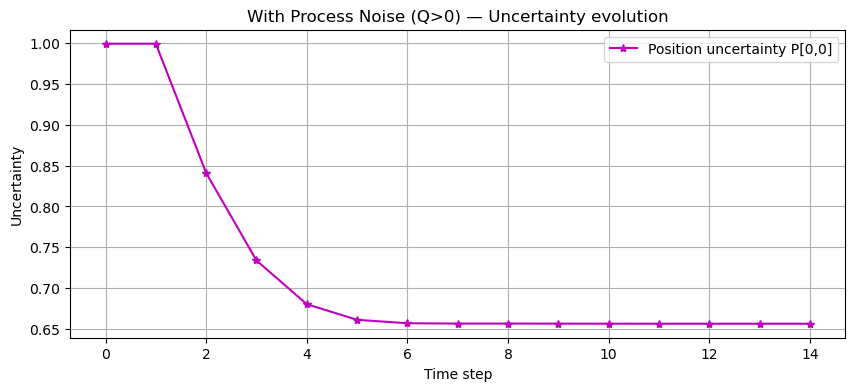

In [36]:


# ----------------------------------------------------------------
# Example 2: Process Noise (Q) — handling system acceleration
# ----------------------------------------------------------------
true_positions = []
true_velocities = []
measurements = []

pos, vel = 0, 1
for t in range(15):
    acc = 0.3 if t > 7 else 0  # acceleration starts mid-way
    vel += acc
    pos += vel
    true_positions.append(pos)
    measurements.append(pos + random.gauss(0, 1))
    true_velocities.append(vel)

x = matrix([[0.], [0.]])
P = matrix([[1000., 0.], [0., 1000.]])
R = matrix([[1.]])
Q = matrix([[0.1, 0.1], [0.1, 0.3]])  # process noise

x, P, positions, velocities, uncertainties = kalman_filter(x, P)
plot_results("With Process Noise (Q>0)", measurements, positions, velocities, uncertainties)

# 👉 Insight:
#   - Adding Q allows the filter to adapt to unmodeled accelerations.
#   - Without Q, filter lags behind when motion changes unexpectedly.




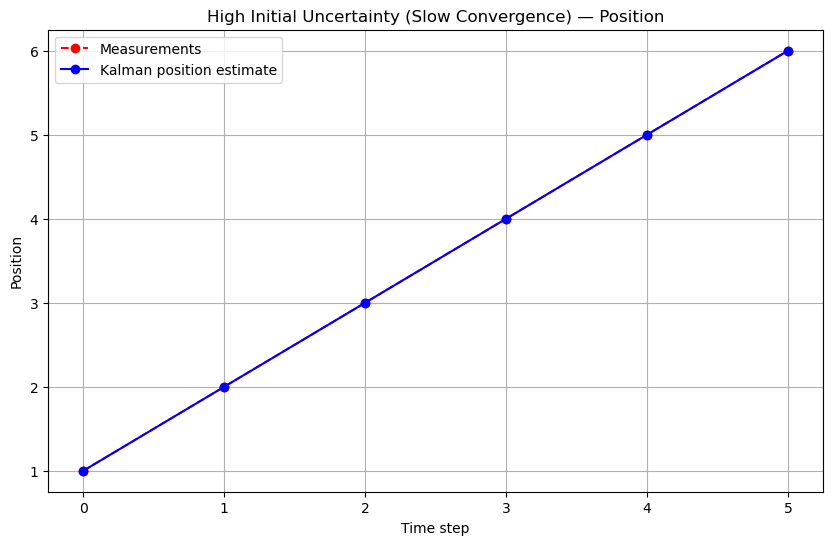

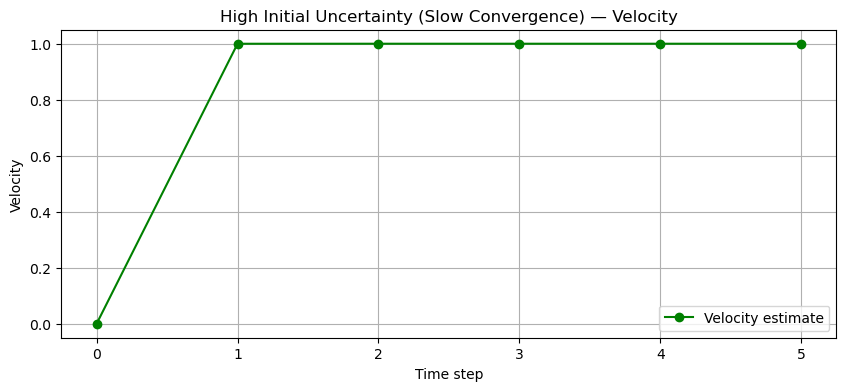

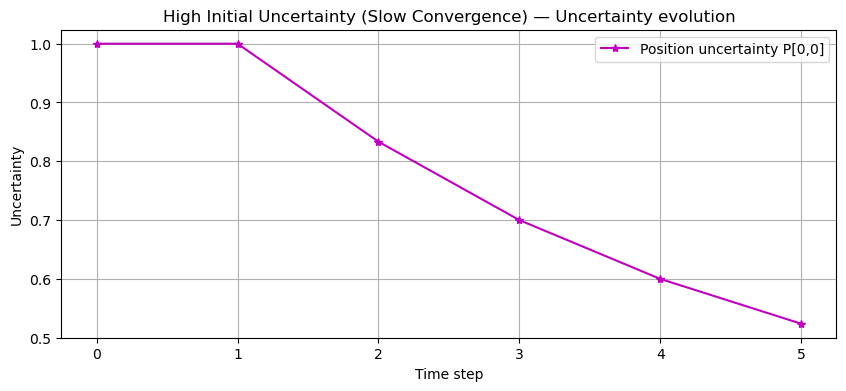

In [37]:
# ----------------------------------------------------------------
# Example 3: Slow Convergence with Large Initial Uncertainty
# ----------------------------------------------------------------

measurements = [1, 2, 3, 4, 5, 6]
Q = matrix([[0., 0.], [0., 0.]])
R = matrix([[1.]])
x = matrix([[0.], [0.]])
P = matrix([[10000., 0.], [0., 10000.]])  # huge uncertainty
x, P, positions, velocities, uncertainties = kalman_filter(x, P)
plot_results("High Initial Uncertainty (Slow Convergence)", measurements, positions, velocities, uncertainties)

# 👉 Insight:
#   - Very large P₀ means the filter initially trusts new measurements a lot.
#   - Estimates start unstable, then converge as confidence grows.
# Occhio Nacho: the first measurement gets almost 100% of the trust, pulling the estimate immediately toward the measurement
#— so you don’t see a gradual convergence, because the update instantly corrects the state.



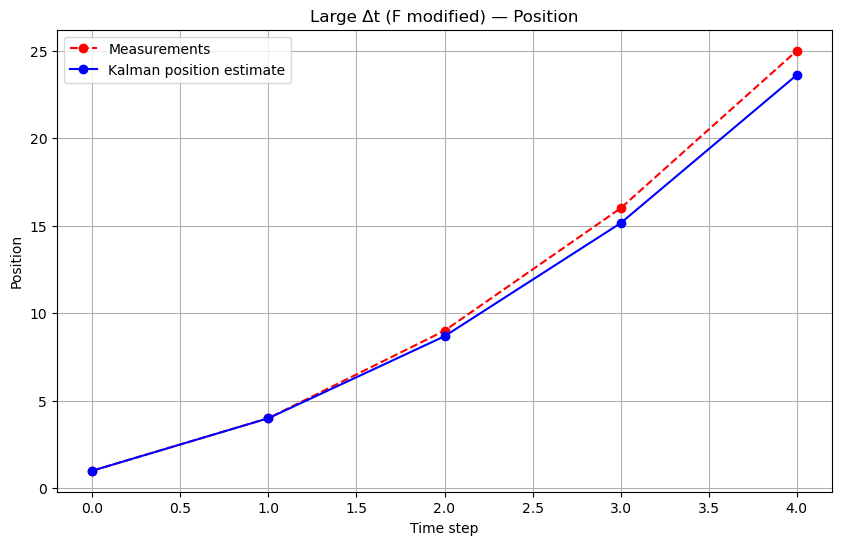

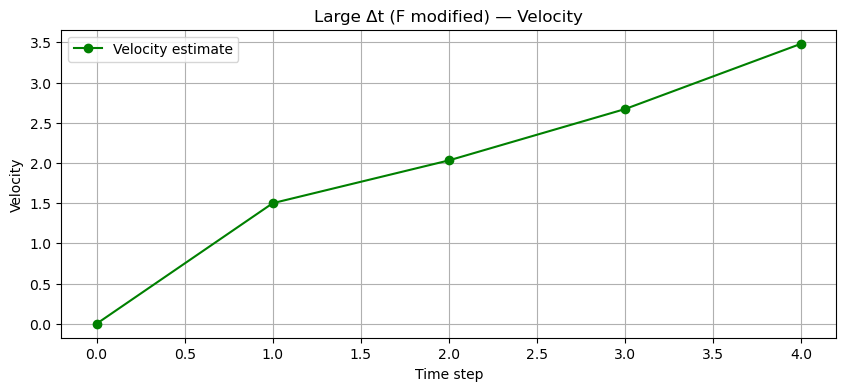

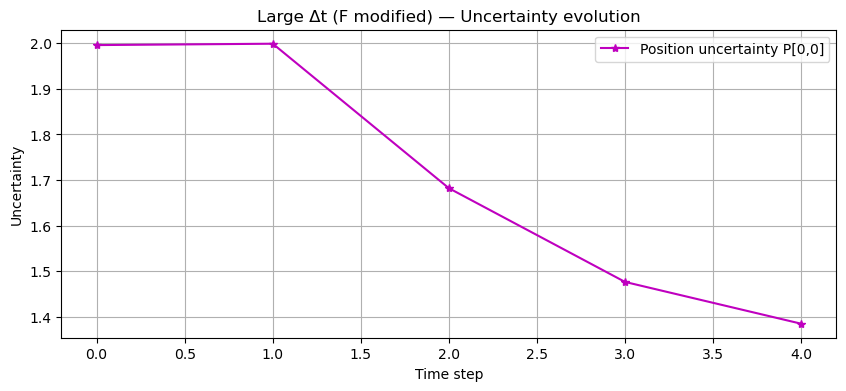

In [38]:

# ----------------------------------------------------------------
# Example 4: Faster Motion (Δt = 2)
# ----------------------------------------------------------------
F = matrix([[1., 2.], [0., 1.]])  # double timestep
measurements = [1, 4, 9, 16, 25]  # faster quadratic growth
x = matrix([[0.], [0.]])
P = matrix([[1000., 0.], [0., 1000.]])
R = matrix([[2.]])
Q = matrix([[0.1, 0.1], [0.1, 0.2]])

x, P, positions, velocities, uncertainties = kalman_filter(x, P)
plot_results("Large Δt (F modified)", measurements, positions, velocities, uncertainties)

# 👉 Insight:
#   - Increasing Δt in F changes how fast position evolves per time step.
#   - The model predicts farther ahead each iteration.




[0, 0.718062648794102, -0.5247874792279978, -0.6475453009257527, -0.9120725219697423, 0.19677676579424186, -1.006699241442669, 0.3598909455218555, 1.0432025319552438, 1.5059339307795363, 2.2604963386722243, 2.779023786722913, 3.051331384389582, 1.6938140145916676, 1.478660048424287, 2.4562864074181965, 4.086411987693788, 4.290094356253426, 4.726408462119038, 6.008470932690244, 2.46321126889354]
[1.2387774307104933, -0.5286384528566989, -2.0508211026110343, -0.8228382112535717, -0.6930192346925997, -1.01106588699387, 1.1756215578963052, -0.28351047604771185, -0.9894869450137809, 1.93148104105154, 1.8125794807319904, 3.864481041329616, 0.1644581631483406, 0.1790088561705634, 4.921634255254468, 1.497450175665274, 2.903268007034622, 4.778947791292098, 7.131923220594686, 4.852092544309811]


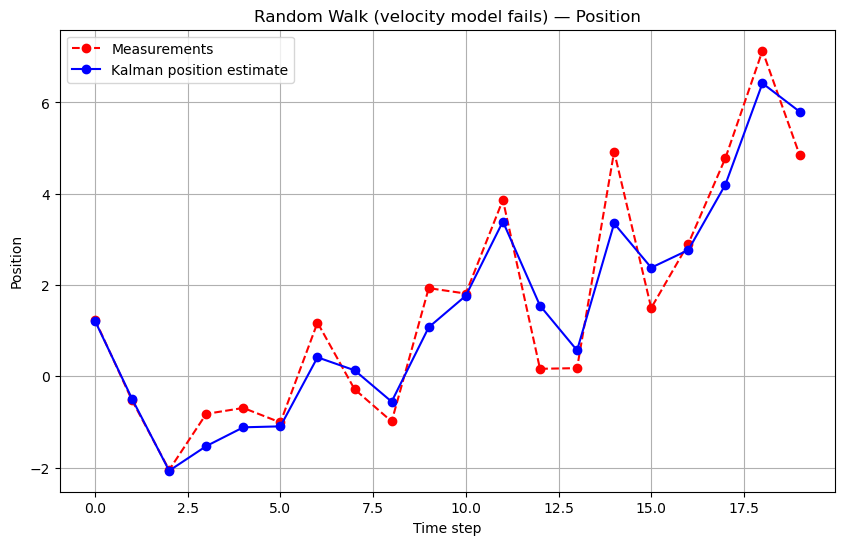

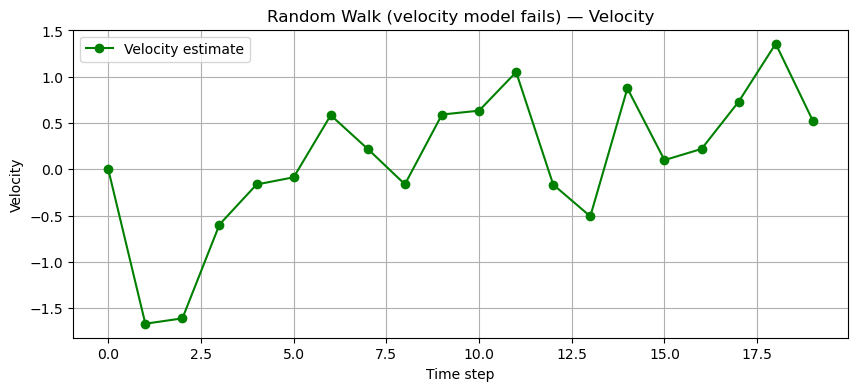

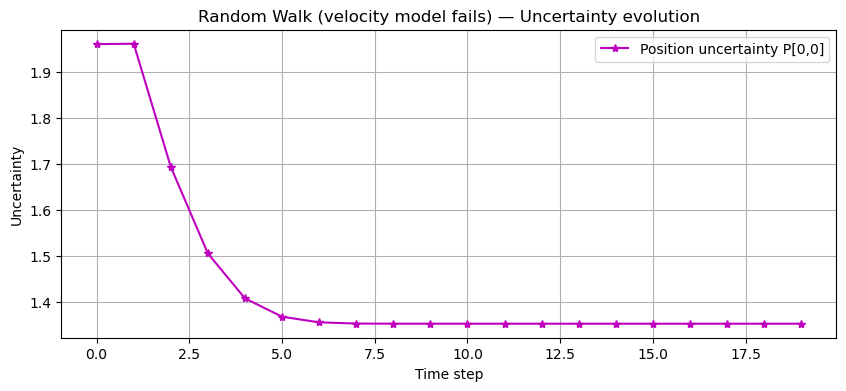

In [39]:
# ----------------------------------------------------------------
# Example 5: Random Walk (model mismatch)
# ----------------------------------------------------------------
measurements = []
true_positions = [0]
for _ in range(20):
    true_positions.append(true_positions[-1] + random.gauss(0, 1))
    measurements.append(true_positions[-1] + random.gauss(0, 1.5))
print(true_positions)
print(measurements)
F = matrix([[1., 1.], [0., 1.]])
R = matrix([[2.]])
Q = matrix([[0.5, 0.], [0., 0.5]])  # assume mild process noise
x = matrix([[0.], [0.]])
P = matrix([[100., 0.], [0., 100.]])

x, P, positions, velocities, uncertainties = kalman_filter(x, P)
plot_results("Random Walk (velocity model fails)", measurements, positions, velocities, uncertainties)

# 👉 Insight:
#   - The constant-velocity assumption breaks for random walks.
#   - Filter smooths noise but cannot follow purely random motion accurately.